In [1]:
%pip install ipympl
#%matplotlib inline
#%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


Environment Setup+angle conversion

In [2]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# Utilities, constants, and policies ONLY (no collection here)
# =========================================================
import os, math, time
import numpy as np
import mujoco

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"   # update if needed
FRAME_SKIP = 10                   # sim steps per control
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# Sign convention: + when pitching toward the head direction
PITCH_SIGN = +1   # flip to -1 if your model's "forward" comes out negative

# Success hysteresis (now in radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 1

# ------------------- Angle helpers (radians) -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)

def angdiff_rad(curr, prev):
    """Minimal signed angle diff in radians, (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi

def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Signed flip angle φ [rad] with your convention:
      0 = upside-down, ±π = upright.
      Positive when pitching toward the head (forward), negative otherwise.

    Numerically-stable via atan2(||z×r||, z·r). Sign from (z×r)·y (about pitch axis).
    """
    R = data.xmat[body_id].reshape(3, 3)     # body->world rotation
    z_w = np.array([0.0, 0.0, 1.0], float)   # world up

    body_z_world = R[:, 2]
    r_w = -body_z_world if roof_is_neg_z else body_z_world  # roof normal in world
    y_w =  R[:, 1]  # body Y (pitch axis) expressed in world

    v = np.cross(z_w, r_w)                   # perpendicular to both
    c = float(np.dot(z_w, r_w))              # cos-like term
    s_axis = float(np.dot(v, y_w))           # sign wrt pitch axis (forward/backward)
    theta = math.atan2(np.linalg.norm(v), clip(c, -1.0, 1.0))  # [0, π] in radians

    # Persistent sign memory to avoid flicker near 0
    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0
    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sgn = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sgn * theta

# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Upside-down spawn with tiny jitter."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.2])  # slight above ground
    data.qvel[:]  = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X (upside-down)
    mujoco.mj_forward(model, data)
    # reset flip-sign memory
    get_signed_flip_rad._flip_sign = 0.0

def find_throttle_ids(model):
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))  # fallback: drive all actuators
    return ids

def apply_throttle(data, ids, u):
    if data.ctrl is not None and data.ctrl.size > 0:
        data.ctrl[:] = 0.0
        for aid in ids:
            data.ctrl[aid] = u

# ------------------- Continuous policies (use radians) -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))

def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Continuous 'swing' throttle (radians):
      - scales with angular rate via tanh(·)
      - optional small Gaussian exploration
    Returns: float in [-1, 1]
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))

# =========================================================
# Flip angle utilities for training (centralized here)
# =========================================================
class FlipTracker:
    """
    Per-env tracker that returns:
      - phi_rad          : upside-down–centered pitch in [-pi, pi]
      - omega_rad_s      : wrapped rate dphi/dt (rad/s)
      - phi_unwrapped_rad: continuous accumulated angle (no wrapping)
    Uses get_signed_flip_rad(...) to keep the definition consistent everywhere.
    """
    def __init__(self, dt_ctrl, roof_is_neg_z=True):
        self.dt = float(dt_ctrl) if dt_ctrl > 0 else 1e-6
        self.roof_is_neg_z = bool(roof_is_neg_z)
        self.prev_phi = None
        self.unwrapped = 0.0

    def reset(self):
        self.prev_phi = None
        self.unwrapped = 0.0
        # also reset the global sign-memory used by get_signed_flip_rad
        get_signed_flip_rad._flip_sign = 0.0

    def step(self, data, body_id):
        """Call after advancing physics for one control interval."""
        phi = get_signed_flip_rad(data, body_id, roof_is_neg_z=self.roof_is_neg_z)
        if self.prev_phi is None:
            dphi = 0.0
        else:
            dphi = angdiff_rad(phi, self.prev_phi)   # minimal signed diff ∈ (-pi, pi]
        omega = dphi / self.dt
        self.unwrapped += dphi
        self.prev_phi = phi
        return float(phi), float(omega), float(self.unwrapped)

def ud_pitch_deg_from_phi(phi_rad):
    """Convert φ to degrees in [-180, 180], where 0°=upside-down, ±180°=upright."""
    deg = ((math.degrees(float(phi_rad)) + 180.0) % 360.0) - 180.0
    return float(deg)

def get_ud_pitch_deg(data, body_id, roof_is_neg_z=True):
    """Direct degrees readout from MuJoCo state using your φ definition."""
    return ud_pitch_deg_from_phi(get_signed_flip_rad(data, body_id, roof_is_neg_z=roof_is_neg_z))

def make_flip_tracker(model, frame_skip=FRAME_SKIP):
    """Factory using env control interval dt_ctrl = model.opt.timestep * FRAME_SKIP."""
    return FlipTracker(dt_ctrl=model.opt.timestep * frame_skip, roof_is_neg_z=True)


Tester for environment setup

In [3]:
# # =========================================================
# # Cell 2 — Debug viewer: UD pitch (degrees) + pitch rate
# # Keys: W=+throttle, S=−throttle, SPACE=0, ESC=quit
# # =========================================================
# import os, time, math
# import numpy as np
# import mujoco
# from mujoco.glfw import glfw
#
# # --- Load model, data, and set initial state using Cell 1 helpers ---
# if not os.path.exists(XML_PATH):
#     raise FileNotFoundError(f"Cannot find XML_PATH: {XML_PATH}")
# model = mujoco.MjModel.from_xml_path(XML_PATH)
# data  = mujoco.MjData(model)
# reset_state(model, data)
#
# # Body / actuators
# chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
# if chassis_id == -1:
#     chassis_id = 0
# throttle_ids = find_throttle_ids(model)
# print(f"Driving actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
# print(f"Initial chassis COM z: {data.xpos[chassis_id,2]:.3f} m")
#
# # --- Viewer setup ---
# if not glfw.init():
#     raise RuntimeError("GLFW init failed")
# window = glfw.create_window(1000, 800, "MonsterTruck — UD Pitch (degrees)", None, None)
# if not window:
#     glfw.terminate()
#     raise RuntimeError("GLFW window creation failed")
# glfw.make_context_current(window)
# glfw.swap_interval(1)  # vsync
#
# cam = mujoco.MjvCamera()
# opt = mujoco.MjvOption()
# scene = mujoco.MjvScene(model, maxgeom=10000)
# context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
# cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90
#
# # --- Keyboard throttle (manual) ---
# throttle = 0.0
# def key_callback(window, key, scancode, action, mods):
#     global throttle
#     if action in (glfw.PRESS, glfw.REPEAT):
#         if key == glfw.KEY_W:       throttle = +1.0
#         elif key == glfw.KEY_S:     throttle = -1.0
#         elif key == glfw.KEY_SPACE: throttle = 0.0
#     elif action == glfw.RELEASE and key in (glfw.KEY_W, glfw.KEY_S):
#         throttle = 0.0
# glfw.set_key_callback(window, key_callback)
#
# # --- Timing ---
# dt_ctrl = model.opt.timestep * FRAME_SKIP  # one control interval
# last_print = time.perf_counter()
# sim_start_wall = last_print
# REALTIME = True
#
# print("Controls: W=+throttle | S=−throttle | SPACE=0 | ESC=quit")
# print("Readout: UD-pitch (deg) 0°=upside-down, ±180°=upright; ω = pitch rate (deg/s).")
#
# # --- Initialize previous angle for rate computation ---
# phi_prev_rad = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
#
# while not glfw.window_should_close(window):
#     if glfw.get_key(window, glfw.KEY_ESCAPE) == glfw.PRESS:
#         break
#
#     # Apply same throttle to all selected actuators
#     apply_throttle(data, throttle_ids, throttle)
#
#     # Step physics faster than render
#     for _ in range(FRAME_SKIP):
#         mujoco.mj_step(model, data)
#
#     # Real-time pacing
#     if REALTIME:
#         target_wall = sim_start_wall + data.time
#         now = time.perf_counter()
#         if now < target_wall:
#             time.sleep(target_wall - now)
#
#     # Follow camera
#     cam.lookat[:] = data.xpos[chassis_id]
#
#     # Render
#     w, h = glfw.get_framebuffer_size(window)
#     if w > 0 and h > 0:
#         mujoco.mjv_updateScene(model, data, opt, None, cam, mujoco.mjtCatBit.mjCAT_ALL, scene)
#         viewport = mujoco.MjrRect(0, 0, w, h)
#         mujoco.mjr_render(viewport, scene, context)
#     glfw.swap_buffers(window)
#     glfw.poll_events()
#
#     # --- Read UD pitch and pitch rate ---
#     phi_rad = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
#     ud_pitch_deg = ud_pitch_deg_from_phi(phi_rad)  # [-180, 180], 0=UD, ±180=UPRIGHT
#
#     # pitch rate ω = dφ/dt using minimal signed angle diff
#     dphi_rad = angdiff_rad(phi_rad, phi_prev_rad)
#     omega_rad = dphi_rad / dt_ctrl
#     omega_deg = np.rad2deg(omega_rad)
#     phi_prev_rad = phi_rad
#
#     # Console readout (~4 Hz)
#     now = time.perf_counter()
#     if now - last_print > 0.25:
#         speed_ratio = data.time / (now - sim_start_wall + 1e-12)
#         pos = data.xpos[chassis_id]
#         print(
#             f"t={data.time:6.2f}s  pos=({pos[0]:+.2f},{pos[1]:+.2f},{pos[2]:+.2f})  "
#             f"UD-pitch={ud_pitch_deg:+7.2f}°  ω={omega_deg:+7.1f}°/s  "
#             f"thr={throttle:+.2f}  ×{speed_ratio:.2f}"
#         )
#         last_print = now
#
# glfw.terminate()
# print("Debug viewer terminated.")


Data Collection for GP

In [4]:
# =========================================================
# Cell 3 — Simple random data collection for GP (MC-style)
# - Collect transitions: (phi, omega_clipped, u) -> (dphi, domega)
# - Just random actions + occasional resets (like MountainCar)
# - NOW: each random action is held for MIN_HOLD_CTRL_STEPS
# =========================================================

import os, time, math
import numpy as np
import mujoco

# ---------- Config ----------
TOTAL_CTRL_STEPS = 10000     # number of control steps => samples
EPISODE_LEN_MAX  = 2000     # max control steps per episode before reset

# Clip angular velocity for GP inputs
OMEGA_CLIP_DEG   = 200.0
OMEGA_CLIP_RAD   = np.deg2rad(OMEGA_CLIP_DEG)

# Optional downsampling stride (like [::3] in MountainCar)
SUBSAMPLE_STRIDE = 3         # set to 1 to keep all samples

# Small prime after reset so it actually moves
PRIME_CTRL_STEPS = 30
PRIME_AMPL       = 0.7

# NEW: minimum time to hold each random input before changing
MIN_HOLD_CTRL_STEPS = 2

PRINT_EVERY      = 1000      # progress print interval


# ---------- Load model & data ----------
if not os.path.exists(XML_PATH):
    raise FileNotFoundError(f"[Cell 3] Cannot find XML_PATH: {XML_PATH}")
model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)

# Control timing + flip tracker
dt_ctrl      = model.opt.timestep * FRAME_SKIP
flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

# Body / actuators
chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)

print(f"[Cell 3] Driving actuators: "
      f"{[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"[Cell 3] FRAME_SKIP={FRAME_SKIP}, dt_ctrl={dt_ctrl:.4f}s")
print(f"[Cell 3] Collecting {TOTAL_CTRL_STEPS} samples (~transitions) with RANDOM actions.")


# ---------- Episode reset (MC-style) ----------
def reset_episode():
    """
    Reset to upside-down, prime a bit so it moves, then return initial (phi, omega).
    """
    reset_state(model, data)
    flip_tracker.reset()

    # brief priming with random sign throttle so it actually swings
    for _ in range(PRIME_CTRL_STEPS):
        sgn = 1.0 if rng.uniform() < 0.5 else -1.0
        apply_throttle(data, throttle_ids, PRIME_AMPL * sgn)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

    # sync tracker after priming
    flip_tracker.reset()
    phi0, omega0, _ = flip_tracker.step(data, chassis_id)
    return float(phi0), float(omega0)


# ---------- Storage for GP training ----------
phi_list      = []   # current φ (rad)
omega_list    = []   # current ω (rad/s, unclipped)
u_list        = []   # throttle u
dphi_list     = []   # Δφ over one control step (rad)
domega_list   = []   # Δω over one control step (rad/s)

# Track throttle range
u_min = +np.inf
u_max = -np.inf

# Success hysteresis (reuse from Cell 1 globals if present)
SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(176.5))
MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
HOLD_NEEDED          = globals().get("HOLD_NEEDED", 1)


# ---------- Main collection loop (random policy) ----------
phi_prev, omega_prev = reset_episode()

hold_success   = 0
steps_done     = 0
episode_step   = 0
start_wall     = time.perf_counter()

# NEW: state for "minimum input time"
u_curr             = 0.0
hold_steps_left_u  = 0    # countdown until we are allowed to change u_curr

print("[Cell 3] Starting RANDOM data collection (MC-style)...")

while steps_done < TOTAL_CTRL_STEPS:
    # Episode reset if too long
    if episode_step >= EPISODE_LEN_MAX:
        phi_prev, omega_prev = reset_episode()
        episode_step   = 0
        hold_success   = 0
        u_curr         = 0.0
        hold_steps_left_u = 0

    # ----- Random action with minimum hold time -----
    # If we've held the current action long enough, sample a new one
    if hold_steps_left_u <= 0:
        u_curr = float(rng.uniform(ACTION_LOW, ACTION_HIGH))
        hold_steps_left_u = MIN_HOLD_CTRL_STEPS
    hold_steps_left_u -= 1

    # Track throttle range
    u_min = min(u_min, u_curr)
    u_max = max(u_max, u_curr)

    # ----- Apply action and step physics for one control interval -----
    apply_throttle(data, throttle_ids, u_curr)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    # Read new state via flip tracker
    phi_curr, omega_curr, _ = flip_tracker.step(data, chassis_id)

    # Compute Δφ and Δω (raw)
    dphi   = angdiff_rad(phi_curr, phi_prev)
    domega = omega_curr - omega_prev

    # Clip ω input for GP stability (like MountainCar's clipped vel)
    omega_clipped = float(np.clip(omega_prev, -OMEGA_CLIP_RAD, OMEGA_CLIP_RAD))

    # ----- Store transition: (prev state, current action) -> deltas -----
    phi_list.append(float(phi_prev))
    omega_list.append(float(omega_clipped))  # note: clipped here
    u_list.append(float(u_curr))
    dphi_list.append(float(dphi))
    domega_list.append(float(domega))

    # Success hysteresis → reset (for diversity)
    if (abs(phi_curr) >= SUCCESS_ENTER_RAD) and (abs(omega_curr) <= MAX_UPRIGHT_RATE_RAD):
        hold_success += 1
    elif abs(phi_curr) < SUCCESS_RELEASE_RAD:
        hold_success = 0

    if hold_success >= HOLD_NEEDED:
        phi_prev, omega_prev = reset_episode()
        episode_step   = 0
        hold_success   = 0
        # reset hold state too
        u_curr             = 0.0
        hold_steps_left_u  = 0
        steps_done        += 1
        continue

    # Prepare for next step
    phi_prev, omega_prev = phi_curr, omega_curr
    steps_done   += 1
    episode_step += 1

    # Periodic progress print
    if steps_done % PRINT_EVERY == 0 or steps_done == TOTAL_CTRL_STEPS:
        elapsed = time.perf_counter() - start_wall
        phi_deg_arr   = np.rad2deg(np.asarray(phi_list,   dtype=np.float32))
        omega_deg_arr = np.rad2deg(np.asarray(omega_list, dtype=np.float32))
        print(
            f"[Cell 3] steps={steps_done}/{TOTAL_CTRL_STEPS}  |  "
            f"φ range (deg) ≈ [{phi_deg_arr.min():+.1f}, {phi_deg_arr.max():+.1f}]  |  "
            f"ω range (deg/s, clipped) ≈ [{omega_deg_arr.min():+.1f}, {omega_deg_arr.max():+.1f}]  |  "
            f"u_range=[{u_min:+.2f}, {u_max:+.2f}]  |  elapsed={elapsed:.1f}s"
        )

print("[Cell 3] Finished random collection.")


# ---------- Pack into arrays (MC-style Δstate) ----------
phi_arr    = np.asarray(phi_list,    dtype=np.float32)
omega_arr  = np.asarray(omega_list,  dtype=np.float32)  # already clipped
u_arr      = np.asarray(u_list,      dtype=np.float32)
dphi_arr   = np.asarray(dphi_list,   dtype=np.float32)
domega_arr = np.asarray(domega_list, dtype=np.float32)

# Stack like MountainCar: X = [state, action], Y = Δstate
X_full = np.stack([phi_arr, omega_arr, u_arr], axis=1)   # (N, 3)
Y_full = np.stack([dphi_arr, domega_arr], axis=1)        # (N, 2)

# Optional subsample stride (same spirit as [::3])
X = X_full[::SUBSAMPLE_STRIDE]
Y = Y_full[::SUBSAMPLE_STRIDE]

print(f"[Cell 3] Done. Full X shape = {X_full.shape}, Y shape = {Y_full.shape}")
print(f"[Cell 3] Subsampled X shape = {X.shape}, Y shape = {Y.shape}")
print(f"[Cell 3] Final φ range (deg) ≈ [{np.rad2deg(phi_arr).min():+.1f}, {np.rad2deg(phi_arr).max():+.1f}]")
print(f"[Cell 3] Final ω range (deg/s, clipped) ≈ [{np.rad2deg(omega_arr).min():+.1f}, {np.rad2deg(omega_arr).max():+.1f}]")
print(f"[Cell 3] Final throttle range: u ∈ [{u_min:+.3f}, {u_max:+.3f}]")

# ---------- Save to disk (same fields as before) ----------
np.savez_compressed(
    "monstertruck_gp_initial_data.npz",
    X=X, Y=Y,
    phi=phi_arr, omega=omega_arr, u=u_arr,
    dphi=dphi_arr, domega=domega_arr,
    dt_ctrl=dt_ctrl,
    u_min=u_min, u_max=u_max,
    omega_clip_deg=OMEGA_CLIP_DEG,
)
print("[Cell 3] Saved dataset to 'monstertruck_gp_initial_data.npz'")


[Cell 3] Driving actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
[Cell 3] FRAME_SKIP=10, dt_ctrl=0.0100s
[Cell 3] Collecting 10000 samples (~transitions) with RANDOM actions.
[Cell 3] Starting RANDOM data collection (MC-style)...
[Cell 3] steps=1000/10000  |  φ range (deg) ≈ [-9.3, +20.4]  |  ω range (deg/s, clipped) ≈ [-192.8, +200.0]  |  u_range=[-1.00, +0.99]  |  elapsed=0.2s
[Cell 3] steps=2000/10000  |  φ range (deg) ≈ [-9.3, +20.4]  |  ω range (deg/s, clipped) ≈ [-200.0, +200.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.3s
[Cell 3] steps=3000/10000  |  φ range (deg) ≈ [-13.9, +20.4]  |  ω range (deg/s, clipped) ≈ [-200.0, +200.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.5s
[Cell 3] steps=4000/10000  |  φ range (deg) ≈ [-13.9, +20.4]  |  ω range (deg/s, clipped) ≈ [-200.0, +200.0]  |  u_range=[-1.00, +1.00]  |  elapsed=0.7s
[Cell 3] steps=5000/10000  |  φ range (deg) ≈ [-13.9, +20.4]  |  ω range (deg/s, clipped) ≈ [-200.0, +200.0]  |  u_r

mor aggressive sampling

In [5]:
# # =========================================================
# # Cell 3 — Initial data collection for GP (active occupancy)
# # - Collect transitions: (phi, omega, u) -> (dphi, domega)
# # - Occupancy-targeted controller in (φ, ω) space, same thrust all wheels
# # - Produces monstertruck_gp_initial_data.npz for GP training
# # =========================================================
#
# import os, math, time
# import numpy as np
# import mujoco
#
# # ---------- Config ----------
# TOTAL_CTRL_STEPS = 20000      # number of control steps => samples
# FRAME_LIMIT_PER_TARGET = 60   # retarget if not reached in this many control steps
#
# # Histogram grid for occupancy (for targeting only)
# BINS_PHI   = 80
# BINS_OMEGA = 80
# OMEGA_LIM  = 90.0             # deg/s: coverage limit for occupancy grid (not GP clip)
#
# # Targeting distribution p ∝ (count + ε)^(-α)
# ALPHA = 1.2
# EPS   = 1.0
#
# # PD controller toward bin center (in φ, ω)
# K_PHI = 2.0                   # stronger to overcome inertia
# K_OMG = 0.6
#
# # Same-thrust action shaping
# HOLD_STEPS       = 6          # sample-and-hold to create torque pulses
# RANDOM_DITHER    = 0.15       # small exploratory dither added to PD output
# STALL_OMG_THRESH = 0.15       # rad/s: below this we consider "stalled" in air
# STALL_PATIENCE   = 25         # steps before injecting a kick
# KICK_STEPS       = 10         # duration of kick pulse
# KICK_AMPL        = 1.0        # kick amplitude in [-1,1]
# PRIME_STEPS      = 8          # post-reset wheel spin-up steps
# PRIME_AMPL       = 0.8
#
# # Success hysteresis (reuse from Cell 1 if present)
# SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
# SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(176.5))
# MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
# HOLD_NEEDED          = globals().get("HOLD_NEEDED", 1)
#
# # --------- GP input ω clipping (for X only, NOT for controller) ----------
# OMEGA_CLIP_DEG = 240.0
# OMEGA_CLIP_RAD = np.deg2rad(OMEGA_CLIP_DEG)
#
# PRINT_EVERY = 1_000
#
# rng_local = np.random.default_rng(int(globals().get("SEED", 0)))
#
#
# def collect_active_occ_for_gp(n_steps=TOTAL_CTRL_STEPS):
#     if not os.path.exists(XML_PATH):
#         raise FileNotFoundError(f"Cannot find {XML_PATH}.")
#     model = mujoco.MjModel.from_xml_path(XML_PATH)
#     data  = mujoco.MjData(model)
#     dt = model.opt.timestep if model.opt.timestep > 0 else 0.001
#     dt_ctrl = dt * FRAME_SKIP
#
#     body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
#     if body_id == -1:
#         raise RuntimeError("Body 'chassis' not found in XML.")
#     throttle_ids = find_throttle_ids(model)
#
#     # --- bin edges / helpers for occupancy in (φ, ω) ---
#     phi_edges = np.linspace(-np.pi, np.pi, BINS_PHI + 1)
#     omg_edges = np.linspace(-np.deg2rad(OMEGA_LIM),
#                             +np.deg2rad(OMEGA_LIM),
#                             BINS_OMEGA + 1)
#     phi_cent  = 0.5 * (phi_edges[:-1] + phi_edges[1:])
#     omg_cent  = 0.5 * (omg_edges[:-1] + omg_edges[1:])
#     phi_bw    = (phi_edges[1] - phi_edges[0])
#     omg_bw    = (omg_edges[1] - omg_edges[0])
#     PHI_TOL   = 0.5 * phi_bw
#     OMG_TOL   = 0.5 * omg_bw
#
#     def _bin_indices(phi, omg):
#         ip = int(np.clip(np.digitize(phi, phi_edges) - 1, 0, BINS_PHI   - 1))
#         io = int(np.clip(np.digitize(omg, omg_edges) - 1, 0, BINS_OMEGA - 1))
#         return ip, io
#
#     def _choose_target(counts):
#         # weights ∝ (count + EPS)^(-ALPHA)
#         weights = (counts + EPS) ** (-ALPHA)
#         p = (weights / np.sum(weights)).ravel()
#         idx = np.random.choice(p.size, p=p)
#         io, ip = np.unravel_index(idx, counts.shape)
#         return phi_cent[ip], omg_cent[io], ip, io
#
#     def _pd_to_target(phi, omg, phi_t, omg_t=0.0):
#         # Minimal signed errors in φ and ω
#         e_phi = angdiff_rad(phi_t, phi)
#         e_omg = omg_t - omg
#         u = K_PHI * e_phi + K_OMG * e_omg
#         # PD → throttle (saturate smoothly)
#         return float(np.tanh(u))
#
#     # --- logs for GP ---
#     phi_log, omg_log, act_log, dphi_log, domg_log = [], [], [], [], []
#     counts = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)
#
#     # === One long run with periodic retargeting ===
#     reset_state(model, data)
#
#     # Prime wheels briefly to inject initial angular momentum (same thrust on all)
#     for _ in range(PRIME_STEPS):
#         a_prime = PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0)
#         apply_throttle(data, throttle_ids, a_prime)
#         mujoco.mj_step(model, data)
#
#     # Initialize φ, ω
#     phi_prev = get_signed_flip_rad(data, body_id)
#     apply_throttle(data, throttle_ids, 0.0)
#     for _ in range(FRAME_SKIP):
#         mujoco.mj_step(model, data)
#     phi_now  = get_signed_flip_rad(data, body_id)
#     omg_prev = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
#     phi_prev = phi_now
#
#     # initial target
#     phi_t, omg_t, ip_t, io_t = _choose_target(counts)
#     steps_on_target = 0
#
#     # action hold & anti-stall state
#     hold_ctr = 0
#     a_hold   = 0.0
#     stall_ctr = 0
#     kick_ctr  = 0
#     kick_sgn  = +1.0
#
#     # success hysteresis counter
#     hold_upright = 0
#
#     start_wall = time.perf_counter()
#
#     for step in range(n_steps):
#         # --- occupancy update from current state ---
#         ip, io = _bin_indices(phi_prev,
#                               np.clip(omg_prev,
#                                       -np.deg2rad(OMEGA_LIM),
#                                       +np.deg2rad(OMEGA_LIM)))
#         counts[io, ip] += 1
#
#         # --- retarget if reached or stuck ---
#         reached = (abs(angdiff_rad(phi_prev, phi_t)) < PHI_TOL) and \
#                   (abs(omg_prev - omg_t) < OMG_TOL)
#         if reached or steps_on_target >= FRAME_LIMIT_PER_TARGET:
#             phi_t, omg_t, ip_t, io_t = _choose_target(counts)
#             steps_on_target = 0
#             stall_ctr = 0
#             kick_ctr  = 0
#
#         # --- controller output (PD + dither) ---
#         a_pd = _pd_to_target(phi_prev, omg_prev, phi_t, omg_t)
#         a_pd += RANDOM_DITHER * (2.0 * rng_local.random() - 1.0)
#
#         # sample-and-hold (constant throttle pulses for HOLD_STEPS)
#         if hold_ctr % HOLD_STEPS == 0:
#             a_hold = float(np.clip(a_pd, ACTION_LOW, ACTION_HIGH))
#         hold_ctr += 1
#         a_cmd = a_hold
#
#         # --- anti-stall: if |ω| stays low, inject a kick ---
#         if abs(omg_prev) < STALL_OMG_THRESH:
#             stall_ctr += 1
#         else:
#             stall_ctr = 0
#             kick_ctr  = 0
#
#         if stall_ctr >= STALL_PATIENCE:
#             if kick_ctr == 0:
#                 # choose kick sign to move toward target φ
#                 desired = angdiff_rad(phi_t, phi_prev)
#                 kick_sgn = +1.0 if desired >= 0.0 else -1.0
#             if kick_ctr < KICK_STEPS:
#                 a_cmd = float(np.clip(kick_sgn * KICK_AMPL, ACTION_LOW, ACTION_HIGH))
#                 kick_ctr += 1
#             else:
#                 stall_ctr = 0
#                 kick_ctr  = 0
#
#         # --- apply action and step physics (SAME throttle to all wheels) ---
#         apply_throttle(data, throttle_ids, a_cmd)
#         for _ in range(FRAME_SKIP):
#             mujoco.mj_step(model, data)
#
#         # --- measure next state ---
#         phi_now  = get_signed_flip_rad(data, body_id)
#         omg_now  = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
#
#         # --- log sample (prev state, action) -> deltas ---
#         phi_log.append(float(phi_prev))
#         omg_log.append(float(omg_prev))
#         act_log.append(float(a_cmd))
#         dphi_log.append(float(angdiff_rad(phi_now, phi_prev)))
#         domg_log.append(float(omg_now - omg_prev))
#
#         # --- success hysteresis → reset for diversity ---
#         if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omg_now) <= MAX_UPRIGHT_RATE_RAD):
#             hold_upright += 1
#         elif abs(phi_now) < SUCCESS_RELEASE_RAD:
#             hold_upright = 0
#
#         if hold_upright >= HOLD_NEEDED:
#             reset_state(model, data)
#             # brief prime again (same thrust)
#             for _ in range(PRIME_STEPS):
#                 a_prime = PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0)
#                 apply_throttle(data, throttle_ids, a_prime)
#                 mujoco.mj_step(model, data)
#
#             phi_prev = get_signed_flip_rad(data, body_id)
#             omg_prev = 0.0
#             hold_upright = 0
#             phi_t, omg_t, ip_t, io_t = _choose_target(counts)
#             steps_on_target = 0
#             hold_ctr = 0
#             a_hold = 0.0
#             stall_ctr = 0
#             kick_ctr  = 0
#             continue
#
#         # --- slide window ---
#         phi_prev, omg_prev = phi_now, omg_now
#         steps_on_target += 1
#
#         # progress print
#         if (step + 1) % PRINT_EVERY == 0 or (step + 1) == n_steps:
#             elapsed = time.perf_counter() - start_wall
#             phi_deg = np.rad2deg(np.asarray(phi_log, dtype=np.float32))
#             omg_deg = np.rad2deg(np.asarray(omg_log, dtype=np.float32))
#             print(
#                 f"[Active-Occ] steps={step+1}/{n_steps} | "
#                 f"φ range (deg) ≈ [{phi_deg.min():+.1f}, {phi_deg.max():+.1f}] | "
#                 f"ω range (deg/s) ≈ [{omg_deg.min():+.1f}, {omg_deg.max():+.1f}] | "
#                 f"u_range=[{min(act_log):+.2f}, {max(act_log):+.2f}] | "
#                 f"elapsed={elapsed:.1f}s"
#             )
#
#     # pack arrays
#     phi_arr  = np.asarray(phi_log,  dtype=np.float32)
#     omg_arr  = np.asarray(omg_log,  dtype=np.float32)
#     act_arr  = np.asarray(act_log,  dtype=np.float32)
#     dphi_arr = np.asarray(dphi_log, dtype=np.float32)
#     domg_arr = np.asarray(domg_log, dtype=np.float32)
#
#     # coverage summary
#     hit_bins = np.count_nonzero(counts)
#     print(f"[Active-Occ] visited bins: {hit_bins} / {counts.size} "
#           f"({100.0*hit_bins/counts.size:.1f}%), "
#           f"min count={counts[counts>0].min() if hit_bins else 0}")
#
#     return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr, counts, (phi_edges, omg_edges), dt_ctrl
#
#
# # ---- Run active collection once ----
# (phi_arr,
#  omega_arr_raw,
#  u_arr,
#  dphi_arr,
#  domega_arr,
#  occ_counts,
#  (phi_edges, omg_edges),
#  dt_ctrl) = collect_active_occ_for_gp(TOTAL_CTRL_STEPS)
#
# # ---------- Prepare GP arrays (with ω clipping) ----------
# omega_arr = np.clip(omega_arr_raw, -OMEGA_CLIP_RAD, OMEGA_CLIP_RAD)
#
# X = np.stack([phi_arr, omega_arr, u_arr], axis=1)   # (N, 3)
# Y = np.stack([dphi_arr, domega_arr], axis=1)        # (N, 2)
#
# print(f"[Cell 3] Done. X shape = {X.shape}, Y shape = {Y.shape}")
# print(f"[Cell 3] Final φ range (deg) ≈ [{np.rad2deg(phi_arr).min():+.1f}, {np.rad2deg(phi_arr).max():+.1f}]")
# print(f"[Cell 3] Final ω range (deg/s, clipped) ≈ [{np.rad2deg(omega_arr).min():+.1f}, {np.rad2deg(omega_arr).max():+.1f}]")
# print(f"[Cell 3] Final throttle range: u ∈ [{u_arr.min():+.3f}, {u_arr.max():+.3f}]")
# print(f"[Cell 3] OMEGA_CLIP_DEG = ±{OMEGA_CLIP_DEG:.1f}°")
#
# # ---------- Save to disk (same format as old Cell 3) ----------
# np.savez_compressed(
#     "monstertruck_gp_initial_data.npz",
#     X=X, Y=Y,
#     phi=phi_arr, omega=omega_arr, u=u_arr,
#     dphi=dphi_arr, domega=domega_arr,
#     dt_ctrl=dt_ctrl,
#     u_min=float(u_arr.min()), u_max=float(u_arr.max()),
#     omega_clip_deg=OMEGA_CLIP_DEG,
# )
# print("[Cell 3] Saved dataset to 'monstertruck_gp_initial_data.npz'")


Visulisation of collected data

[Cell 4] Using phi_arr/omega_arr/u_arr from memory.
[Cell 4] N samples = 10000
[Cell 4] φ range (deg) ≈ [-13.9, +20.9]
[Cell 4] ω range (deg/s) ≈ [-200.0, +200.0]
[Cell 4] u range        ≈ [-1.000, +0.999]


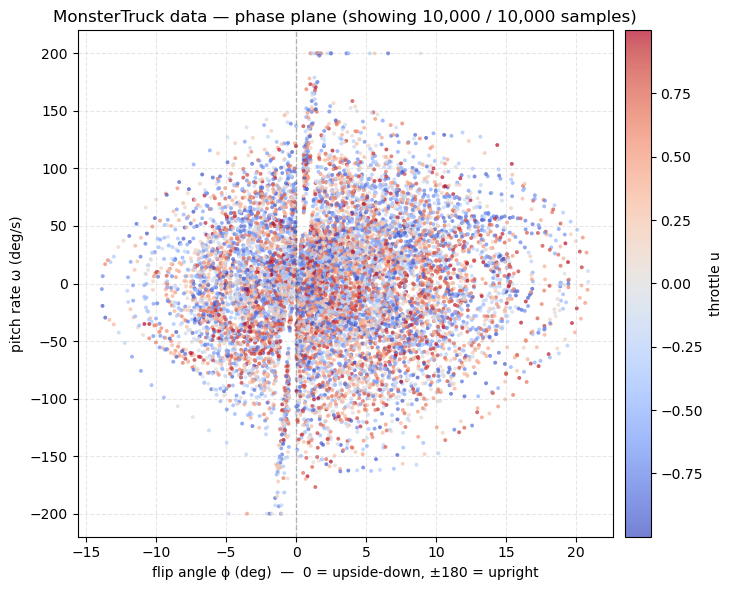

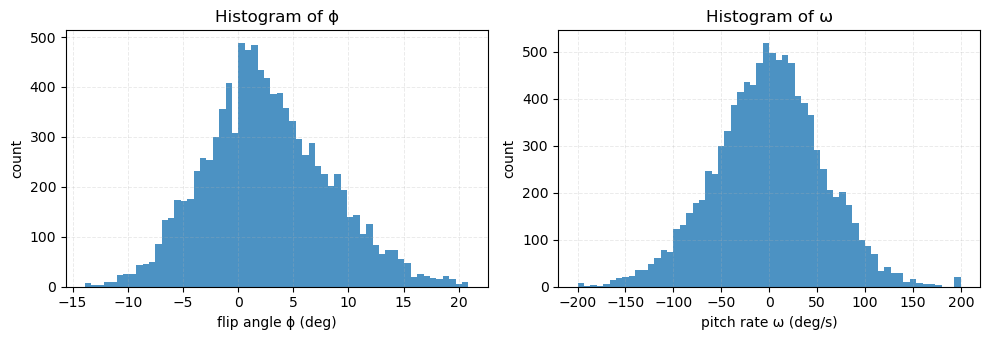

In [6]:
# =========================================================
# Cell 4 — Phase-plane visualization of collected data
#   - Scatter: φ vs ω colored by throttle u
#   - Histograms: φ and ω coverage
# =========================================================
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load data (from memory or from file) ----------
if 'phi_arr' in globals() and 'omega_arr' in globals() and 'u_arr' in globals():
    phi = phi_arr
    omega = omega_arr
    u = u_arr
    print("[Cell 4] Using phi_arr/omega_arr/u_arr from memory.")
else:
    data = np.load("monstertruck_gp_initial_data.npz")
    phi = data["phi"]      # radians
    omega = data["omega"]  # radians/s (clipped)
    u = data["u"]
    print("[Cell 4] Loaded data from 'monstertruck_gp_initial_data.npz'.")

N = phi.shape[0]
phi_deg   = np.rad2deg(phi)
omega_deg = np.rad2deg(omega)

print(f"[Cell 4] N samples = {N}")
print(f"[Cell 4] φ range (deg) ≈ [{phi_deg.min():+.1f}, {phi_deg.max():+.1f}]")
print(f"[Cell 4] ω range (deg/s) ≈ [{omega_deg.min():+.1f}, {omega_deg.max():+.1f}]")
print(f"[Cell 4] u range        ≈ [{u.min():+.3f}, {u.max():+.3f}]")


# ---------- Scatter: phase plane with action color ----------
MAX_POINTS = 50_000
rng_vis = np.random.default_rng(0)
if N > MAX_POINTS:
    idx = rng_vis.choice(N, size=MAX_POINTS, replace=False)
    N_show = MAX_POINTS
else:
    idx = slice(None)
    N_show = N

fig, ax = plt.subplots(figsize=(7.5, 6))
sc = ax.scatter(
    phi_deg[idx],
    omega_deg[idx],
    c=u[idx],
    s=8,
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="none",
)

ax.set_xlabel("flip angle ϕ (deg)  —  0 = upside-down, ±180 = upright")
ax.set_ylabel("pitch rate ω (deg/s)")
ax.set_title(f"MonsterTruck data — phase plane (showing {N_show:,} / {N:,} samples)")

# vertical line at upside-down and (optionally) upright bands
ax.axvline(0.0, color="k", linestyle="--", alpha=0.25, linewidth=1.0)
ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)

cb = fig.colorbar(sc, ax=ax, pad=0.02)
cb.set_label("throttle u")

plt.tight_layout()
plt.show()


# ---------- Histograms: φ and ω marginal distributions ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(phi_deg, bins=60, alpha=0.8)
axes[0].set_xlabel("flip angle ϕ (deg)")
axes[0].set_ylabel("count")
axes[0].set_title("Histogram of ϕ")

axes[1].hist(omega_deg, bins=60, alpha=0.8)
axes[1].set_xlabel("pitch rate ω (deg/s)")
axes[1].set_ylabel("count")
axes[1].set_title("Histogram of ω")

for ax in axes:
    ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# Cell 5 — GP dynamics model for MonsterTruck (subsampled)
#   - Models: (phi, omega_clipped, u) -> (Δphi, Δomega)
#   - Two separate ExactGPs (one per output dim)
#   - Normalization of X, Y
#   - Stratified subsampling over (phi, omega) for GP training
#   - Numpy wrapper: gp_predict_delta_numpy(X_query)
#   - Supports incremental retraining via append_and_fit(...)
# ============================================================
import math
import numpy as np
import torch
import gpytorch

# ---------- Hyperparam: max points used for GP training ----------
# You can tune this. 3000–8000 is a good range.
MAX_TRAIN_POINTS = 20000

# ---------- Load data (X, Y) ----------
# Prefer in-memory X, Y from Cell 3; fall back to npz
if 'X' in globals() and 'Y' in globals():
    X_np = X.astype(np.float32)
    Y_np = Y.astype(np.float32)
    print("[Cell 5] Using X, Y from memory.")
else:
    data = np.load("monstertruck_gp_initial_data.npz")
    X_np = data["X"].astype(np.float32)  # (N, 3): [phi, omega_clipped, u]
    Y_np = data["Y"].astype(np.float32)  # (N, 2): [dphi, domega]
    print("[Cell 5] Loaded 'monstertruck_gp_initial_data.npz'.")

N, Dx = X_np.shape
_, Dy = Y_np.shape
assert Dx == 3 and Dy == 2, f"Unexpected shapes: X={X_np.shape}, Y={Y_np.shape}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Cell 5] Using device: {device}")


# ---------- Simple standardizer ----------
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, x: np.ndarray):
        self.mean = x.mean(axis=0, keepdims=True).astype(np.float32)
        self.std = x.std(axis=0, keepdims=True).astype(np.float32)
        # Avoid division by zero
        self.std[self.std < 1e-8] = 1.0

    def transform(self, x: np.ndarray) -> np.ndarray:
        return (x - self.mean) / self.std

    def inverse_transform(self, x: np.ndarray) -> np.ndarray:
        return x * self.std + self.mean


# ---------- Exact GP model (single-output) ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ---------- GP manager for one output dimension ----------
class GPManager:
    def __init__(self, kernel='RBF', lr=0.05, iters=250,
                 max_train_points: int | None = MAX_TRAIN_POINTS,
                 seed: int = 0):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.max_train_points = max_train_points

        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.model = None
        self.likelihood = None

        # Full dataset (grow over time, used for logging/visualisation)
        self.X_all = None
        self.Y_all = None

        # RNG for subsampling
        self._rng = np.random.default_rng(seed)

    def _select_train_subset(self, X: np.ndarray, y: np.ndarray):
        """
        Return (X_fit, y_fit) used for GP training.

        Strategy:
          - If N <= max_train_points: use all.
          - Else: stratified subsampling over (phi, omega) to cover
                  the phase-plane more uniformly.
        """
        if (self.max_train_points is None) or (X.shape[0] <= self.max_train_points):
            print(f"[GPManager] Using all {X.shape[0]} points for training.")
            return X, y

        N = X.shape[0]
        n_target = self.max_train_points

        # ------------- Stratified over (phi, omega) -------------
        phi = X[:, 0]
        omega = X[:, 1]

        # Use global omega clip if available; else fallback
        omega_clip = globals().get("OMEGA_CLIP_RAD", math.radians(200.0))

        phi_min, phi_max = -math.pi, math.pi
        om_min, om_max = -omega_clip, omega_clip

        # Normalize to [0,1] then bin
        bins_phi = 40
        bins_omega = 40

        phi_clipped = np.clip(phi, phi_min, phi_max)
        om_clipped = np.clip(omega, om_min, om_max)

        phi_norm = (phi_clipped - phi_min) / (phi_max - phi_min + 1e-8)
        om_norm  = (om_clipped  - om_min)  / (om_max - om_min + 1e-8)

        i_phi = np.minimum((phi_norm * bins_phi).astype(int),  bins_phi - 1)
        i_om  = np.minimum((om_norm  * bins_omega).astype(int), bins_omega - 1)

        bin_ids = i_phi * bins_omega + i_om

        from collections import defaultdict
        bins_dict = defaultdict(list)
        for idx, b in enumerate(bin_ids):
            bins_dict[int(b)].append(idx)

        nonempty_bins = list(bins_dict.keys())
        M = len(nonempty_bins)

        if M == 0:
            # Shouldn't really happen; fallback to uniform random
            idx = self._rng.choice(N, size=n_target, replace=False)
            X_fit = X[idx]
            y_fit = y[idx]
            print(f"[GPManager] Fallback random subsampling {N} -> {X_fit.shape[0]} points.")
            return X_fit, y_fit

        n_per_bin = n_target // M
        remainder = n_target % M

        selected_idx = []

        # First pass: sample up to n_per_bin per bin
        for b in nonempty_bins:
            inds = bins_dict[b]
            if len(inds) <= n_per_bin:
                selected_idx.extend(inds)
            else:
                chosen = self._rng.choice(inds, size=n_per_bin, replace=False)
                selected_idx.extend(chosen)

        # If we still need more points, sample extra from remaining ones
        if len(selected_idx) < n_target:
            remaining = n_target - len(selected_idx)
            all_indices = np.arange(N, dtype=int)
            mask_sel = np.zeros(N, dtype=bool)
            mask_sel[selected_idx] = True
            candidates = all_indices[~mask_sel]
            if candidates.size > 0:
                extra = self._rng.choice(
                    candidates,
                    size=min(remaining, candidates.size),
                    replace=False,
                )
                selected_idx.extend(extra)

        selected_idx = np.asarray(selected_idx, dtype=int)
        if selected_idx.shape[0] > n_target:
            selected_idx = self._rng.choice(selected_idx, size=n_target, replace=False)

        X_fit = X[selected_idx]
        y_fit = y[selected_idx]

        print(f"[GPManager] Stratified subsampling {N} -> {X_fit.shape[0]} points for training.")
        return X_fit, y_fit

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Train GP on given X, y (numpy arrays).
        Overwrites internal dataset with (X, y).
        Uses at most max_train_points for actual GP training,
        with stratified selection over (phi, omega).
        """
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

        # Store full dataset for later analysis/visualization
        self.X_all = X.copy()
        self.Y_all = y.copy()

        # Subsample for training (stratified)
        X_fit, y_fit = self._select_train_subset(X, y)

        # Fit scalers on the training subset
        self.x_scaler.fit(X_fit)
        self.y_scaler.fit(y_fit)

        Xn = self.x_scaler.transform(X_fit)
        yn = self.y_scaler.transform(y_fit).ravel()  # 1D target

        train_x = torch.from_numpy(Xn).to(device)
        train_y = torch.from_numpy(yn).to(device)

        # Build GP
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
        self.model = ExactGPModel(train_x, train_y, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1]).to(device)

        self.model.train()
        self.likelihood.train()

        # Optimizer + marginal likelihood
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        print(f"[GPManager] Training GP ({self.kernel}) on {X_fit.shape[0]} points "
              f"(full buffer={X.shape[0]}).")
        for i in range(self.iters):
            optimizer.zero_grad()
            output = self.model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()

            if (i + 1) % 50 == 0 or i == 0 or i == self.iters - 1:
                print(f"  iter {i+1:4d}/{self.iters} | loss = {loss.item():.4f}")

        print("[GPManager] Training done.")

    def append_and_fit(self, X_new: np.ndarray, y_new: np.ndarray, max_points: int | None = None):
        """
        Append new (X_new, y_new) to existing dataset and retrain.
        If max_points is not None, keep only the most recent max_points in the buffer.
        (Training subset is still limited by self.max_train_points, stratified.)
        """
        X_new = np.asarray(X_new, dtype=np.float32)
        y_new = np.asarray(y_new, dtype=np.float32).reshape(-1, 1)

        if self.X_all is None:
            X_cat = X_new
            Y_cat = y_new
        else:
            X_cat = np.concatenate([self.X_all, X_new], axis=0)
            Y_cat = np.concatenate([self.Y_all, y_new], axis=0)

        if max_points is not None and X_cat.shape[0] > max_points:
            X_cat = X_cat[-max_points:]
            Y_cat = Y_cat[-max_points:]

        print(f"[GPManager] Retrain buffer size={X_cat.shape[0]} (new={X_new.shape[0]}).")
        self.fit(X_cat, Y_cat)

    @torch.no_grad()
    def predict(self, X_query: np.ndarray):
        """
        Predict mean and variance for X_query (numpy).
        Returns: mean (N,), var (N,)
        """
        assert self.model is not None, "GP not trained yet."

        self.model.eval()
        self.likelihood.eval()

        Xq = np.asarray(X_query, dtype=np.float32)
        Xq_n = self.x_scaler.transform(Xq)
        x_t = torch.from_numpy(Xq_n).to(device)

        with gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(x_t))

        mean_n = pred.mean.detach().cpu().numpy()
        var_n = pred.variance.detach().cpu().numpy()

        # Un-normalize mean; adjust variance for scaling
        mean = self.y_scaler.inverse_transform(mean_n.reshape(-1, 1)).ravel()
        # If y = s * y_n + m, then Var[y] = s^2 * Var[y_n]
        y_std = self.y_scaler.std.ravel()[0]
        var = (y_std ** 2) * var_n
        return mean.astype(np.float32), var.astype(np.float32)


# ---------- Train two GPs: for Δphi and Δomega ----------
gps = [GPManager(kernel='RBF', lr=0.05, iters=600, max_train_points=MAX_TRAIN_POINTS, seed=0),
       GPManager(kernel='RBF', lr=0.05, iters=600, max_train_points=MAX_TRAIN_POINTS, seed=1)]

# Δphi GP
gps[0].fit(X_np, Y_np[:, 0])
# Δomega GP
gps[1].fit(X_np, Y_np[:, 1])

print("[Cell 5] Trained two GP models for Δphi and Δomega.")


# ---------- Numpy wrapper: single-step dynamics ----------
def gp_predict_delta_numpy(X_query: np.ndarray):
    """
    Given X_query (N, 3) = [phi, omega_clipped, u],
    return:
        dphi_mean (N,), dphi_var (N,),
        domega_mean (N,), domega_var (N,)
    All numpy float32 arrays.
    """
    dphi_mean, dphi_var = gps[0].predict(X_query)
    domega_mean, domega_var = gps[1].predict(X_query)
    return dphi_mean, dphi_var, domega_mean, domega_var


# ---------- Meta info we may want later (for MPPI, etc.) ----------
gp_data_meta = dict(
    dt_ctrl=float(dt_ctrl),
    omega_clip_rad=float(OMEGA_CLIP_RAD),
    N_train=int(N),
    max_train_points=int(MAX_TRAIN_POINTS),
)

print("[Cell 5] gp_predict_delta_numpy(...) and gp_data_meta ready.")


[Cell 5] Using X, Y from memory.
[Cell 5] Using device: cuda
[GPManager] Using all 3334 points for training.
[GPManager] Training GP (RBF) on 3334 points (full buffer=3334).
  iter    1/600 | loss = 1.0168
  iter   50/600 | loss = 0.8523
  iter  100/600 | loss = 0.8505
  iter  150/600 | loss = 0.8497
  iter  200/600 | loss = 0.8492
  iter  250/600 | loss = 0.8483
  iter  300/600 | loss = 0.8480
  iter  350/600 | loss = 0.8476
  iter  400/600 | loss = 0.8481
  iter  450/600 | loss = 0.8472
  iter  500/600 | loss = 0.8472
  iter  550/600 | loss = 0.8468
  iter  600/600 | loss = 0.8466
[GPManager] Training done.
[GPManager] Using all 3334 points for training.
[GPManager] Training GP (RBF) on 3334 points (full buffer=3334).
  iter    1/600 | loss = 1.2224
  iter   50/600 | loss = 1.0760
  iter  100/600 | loss = 1.0565
  iter  150/600 | loss = 1.0517
  iter  200/600 | loss = 1.0460
  iter  250/600 | loss = 1.0390
  iter  300/600 | loss = 1.0484
  iter  350/600 | loss = 1.0392
  iter  400/60

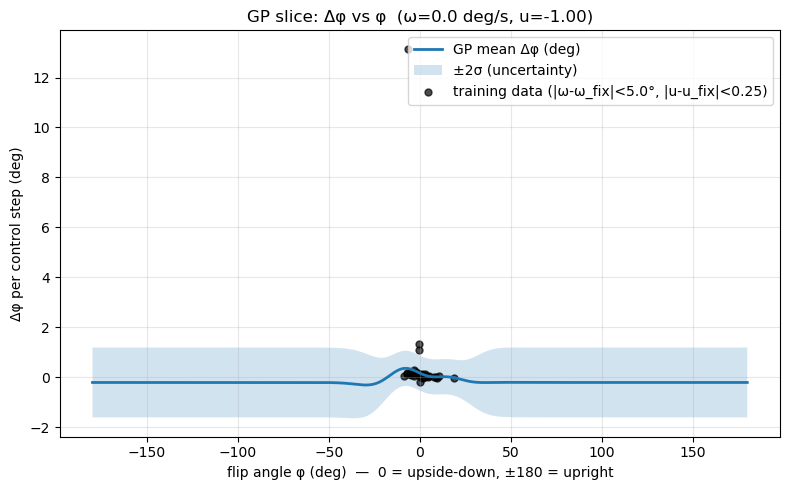

[Cell 6] Using gp.X_all[:, 0] for φ distribution.
[Cell 6] N samples (for histogram) = 3334
[Cell 6] φ range (deg) ≈ [-13.81, +20.81]


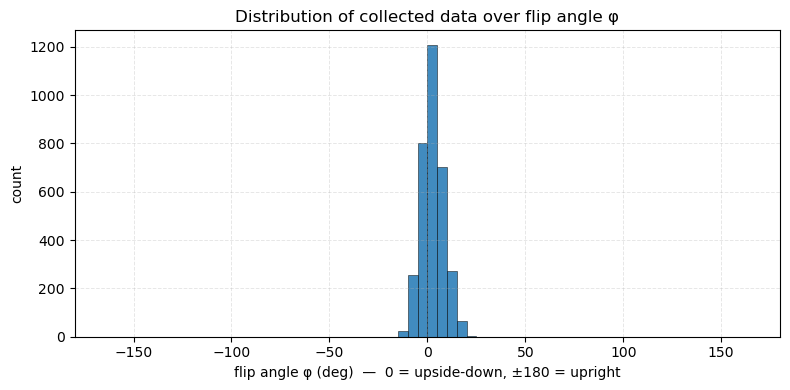

In [8]:
# ============================================================
# Cell 6 — GP slice (Δφ) + data distribution over φ
#   - Plot 1: GP mean ± 2σ vs φ at fixed (ω, u)
#   - Plot 2: Histogram of collected φ over [-180°, 180°]
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δφ model
# --------------------------------------------------------
gp = gps[0]        # GP for Δφ

# Fix angular rate and throttle for the slice
omega_fixed = 0.0      # rad/s (≈ 0 deg/s)
u_fixed     = -1.0     # throttle in [-1, 1]

# --------------------------------------------------------
# Define φ grid (in radians)
# --------------------------------------------------------
phi_min, phi_max = -np.pi, np.pi   # full range [-180°, +180°]
phi_grid = np.linspace(phi_min, phi_max, 400, dtype=np.float32)

# Construct query points [φ, ω_fixed, u_fixed]
X_query = np.column_stack([
    phi_grid,
    np.full_like(phi_grid, omega_fixed, dtype=np.float32),
    np.full_like(phi_grid, u_fixed, dtype=np.float32),
])

# --------------------------------------------------------
# Predict GP mean and std (in radians)
# --------------------------------------------------------
Mean_rad, Var = gp.predict(X_query)
Var = np.maximum(Var, 0.0)  # numerical safety
Std_rad = np.sqrt(Var)

# Convert to degrees for plotting
phi_grid_deg = np.rad2deg(phi_grid)
Mean_deg     = np.rad2deg(Mean_rad)
Std_deg      = np.rad2deg(Std_rad)

# --------------------------------------------------------
# Overlay training data near (ω_fixed, u_fixed)
# --------------------------------------------------------
X_all = gp.X_all         # shape (N, 3): [φ, ω_clipped, u]
Y_all = gp.Y_all         # shape (N, 1): Δφ in radians

if X_all is None or Y_all is None:
    print("[Cell 6] No training data stored in gp.X_all / gp.Y_all.")
    phi_train_deg  = np.array([])
    dphi_train_deg = np.array([])
else:
    Y_all_rad = Y_all.ravel()

    # Select points close to the chosen slice in ω and u
    omega_tol_deg = 5.0          # +/- 5 deg/s
    u_tol         = 0.25         # +/- 0.25 in throttle

    mask = (
        (np.abs(X_all[:, 1] - omega_fixed) < np.deg2rad(omega_tol_deg)) &
        (np.abs(X_all[:, 2] - u_fixed)     < u_tol)
    )

    phi_train_deg  = np.rad2deg(X_all[mask, 0])
    dphi_train_deg = np.rad2deg(Y_all_rad[mask])

# --------------------------------------------------------
# Plot 1: GP mean ± 2σ as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(phi_grid_deg, Mean_deg, lw=2, label='GP mean Δφ (deg)')

plt.fill_between(
    phi_grid_deg,
    Mean_deg - 2 * Std_deg,
    Mean_deg + 2 * Std_deg,
    alpha=0.2,
    label='±2σ (uncertainty)'
)

# Overlay training data
if phi_train_deg.size > 0:
    plt.scatter(
        phi_train_deg,
        dphi_train_deg,
        color='k',
        s=25,
        alpha=0.7,
        label=f'training data (|ω-ω_fix|<{omega_tol_deg}°, |u-u_fix|<{u_tol})'
    )
else:
    print("[Cell 6] No training points matched the (ω_fixed, u_fixed) slice mask.")

plt.xlabel("flip angle φ (deg)  —  0 = upside-down, ±180 = upright")
plt.ylabel("Δφ per control step (deg)")
plt.title(f"GP slice: Δφ vs φ  (ω={np.rad2deg(omega_fixed):.1f} deg/s, u={u_fixed:+.2f})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2 — Data distribution over flip angle φ (deg)
# ============================================================

# Get φ for histogram
if X_all is not None:
    phi_all = X_all[:, 0].astype(np.float32)   # radians
    print("[Cell 6] Using gp.X_all[:, 0] for φ distribution.")
elif 'phi_arr' in globals():
    phi_all = phi_arr.astype(np.float32)
    print("[Cell 6] Using phi_arr from collection for φ distribution.")
elif 'X_np' in globals():
    phi_all = X_np[:, 0].astype(np.float32)
    print("[Cell 6] Using X_np[:, 0] for φ distribution.")
else:
    data = np.load("monstertruck_gp_initial_data.npz")
    phi_all = data["phi"].astype(np.float32)
    print("[Cell 6] Loaded phi from 'monstertruck_gp_initial_data.npz' for distribution.")

phi_deg_all = np.rad2deg(phi_all)
phi_min_all, phi_max_all = phi_deg_all.min(), phi_deg_all.max()
N = phi_deg_all.shape[0]

print(f"[Cell 6] N samples (for histogram) = {N}")
print(f"[Cell 6] φ range (deg) ≈ [{phi_min_all:+.2f}, {phi_max_all:+.2f}]")

# Histogram over [-180, 180]
bins = 72  # 5° bins: 360 / 5 = 72
bin_edges = np.linspace(-180.0, 180.0, bins + 1)

plt.figure(figsize=(8, 4))
plt.hist(phi_deg_all, bins=bin_edges, alpha=0.85, edgecolor='k', linewidth=0.4)

plt.xlabel("flip angle φ (deg)  —  0 = upside-down, ±180 = upright")
plt.ylabel("count")
plt.title("Distribution of collected data over flip angle φ")
plt.xlim([-180, 180])
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)
plt.tight_layout()
plt.show()


|GP Training Script

In [9]:
# ============================================================
# Cell 7 — GP-based dynamics + task & exploration costs
# ============================================================
import numpy as np

# ---------- Helpers ----------
def clip_angle_pi(phi):
    return ((phi + np.pi) % (2.0 * np.pi)) - np.pi


def is_upright_success(phi, omega):
    return (abs(phi) >= SUCCESS_ENTER_RAD) and (abs(omega) <= MAX_UPRIGHT_RATE_RAD)


# ---------- GP-based single-step dynamics ----------
def gp_step(state, action):
    phi, omega = float(state[0]), float(state[1])

    omega_in = float(np.clip(
        omega,
        -gp_data_meta["omega_clip_rad"],
        +gp_data_meta["omega_clip_rad"]
    ))

    X_query = np.array([[phi, omega_in, float(action)]], dtype=np.float32)

    dphi_mean, dphi_var, domega_mean, domega_var = gp_predict_delta_numpy(X_query)

    dphi_m   = float(dphi_mean[0])
    domega_m = float(domega_mean[0])
    v_phi    = float(dphi_var[0])
    v_omega  = float(domega_var[0])

    phi_next   = clip_angle_pi(phi + dphi_m)
    omega_next = omega + domega_m

    var_total = v_phi + v_omega

    next_state = np.array([phi_next, omega_next], dtype=np.float32)
    return next_state, var_total


# ---------- Exploration cost ----------
def explore_cost_step(var_total, eps=1e-8):
    v = max(float(var_total), eps)
    return -np.log(v)


# ---------- Task cost weights ----------
TASK_COST_WEIGHTS = dict(
    w_angle=200.0,
    w_rate=20.0,
    w_jerk=1.0,
    w_time=1.5,
    angle_norm=np.pi,
    omega_ref=np.deg2rad(120.0),
)


def task_cost_step(state, action, w=TASK_COST_WEIGHTS):
    phi, omega = float(state[0]), float(state[1])

    angle_err = np.pi - min(abs(phi), np.pi)
    angle_dist = (angle_err / w["angle_norm"])
    angle_dist = np.clip(angle_dist, 0.0, 1.0)

    c_angle = w["w_angle"] * (angle_dist**2)

    closeness = 1.0 - angle_dist
    omega_norm = omega / w["omega_ref"]
    c_rate = w["w_rate"] * closeness * (omega_norm**2)

    c_time = w["w_time"]

    return c_angle + c_rate + c_time


def rollout_cost_from_actions(
    state0,
    actions,
    wt_task=1.0,
    wt_explore=0.0,
    gamma=0.99,
    early_stop_on_success=True
):
    state = np.array(state0, dtype=np.float32)
    H = len(actions)

    J_task = 0.0
    J_expl = 0.0
    disc = 1.0

    u_prev = 0.0

    for t in range(H):
        u_t = float(actions[t])

        next_state, var_total = gp_step(state, u_t)

        c_task_core = task_cost_step(state, u_t)

        du = u_t - u_prev
        c_jerk = TASK_COST_WEIGHTS["w_jerk"] * (du**2)

        c_task = c_task_core + c_jerk

        c_expl = explore_cost_step(var_total)

        J_task += disc * c_task
        J_expl += disc * c_expl

        state = next_state
        disc *= gamma
        u_prev = u_t

        if early_stop_on_success and is_upright_success(state[0], state[1]):
            break

    total_cost = wt_task * J_task + wt_explore * J_expl
    return float(total_cost), float(J_task), float(J_expl)


In [10]:
# ============================================================
# Cell 8 — MPPI controller (GP-based) for MonsterTruck flip
# ============================================================
import numpy as np

class MPPIController:
    def __init__(
        self,
        H=100,
        K=256,
        sigma=0.6,
        lam=1.0,
        gamma=0.99,
        wt_task=1.0,
        wt_explore=0.0,
        action_low=-1.0,
        action_high=1.0,
        seed=0,
    ):
        self.H = H
        self.K = K
        self.sigma = float(sigma)
        self.lam = float(lam)
        self.gamma = float(gamma)
        self.wt_task = float(wt_task)
        self.wt_explore = float(wt_explore)
        self.action_low = float(action_low)
        self.action_high = float(action_high)

        self.rng = np.random.default_rng(seed)
        self.base_actions = np.zeros(self.H, dtype=np.float32)

    def _sample_action_sequences(self):
        noise = self.rng.normal(
            loc=0.0,
            scale=self.sigma,
            size=(self.K, self.H)
        ).astype(np.float32)

        U = self.base_actions[None, :] + noise
        U = np.clip(U, self.action_low, self.action_high)
        return U

    def act(self, state, u_prev=0.0):
        state0 = np.array(state, dtype=np.float32).copy()
        u_prev = float(u_prev)

        U = self._sample_action_sequences()  # (K, H)

        costs = np.zeros(self.K, dtype=np.float64)
        J_task_arr = np.zeros(self.K, dtype=np.float64)
        J_expl_arr = np.zeros(self.K, dtype=np.float64)

        for k in range(self.K):
            a_seq = U[k]

            cost, J_task, J_expl = rollout_cost_from_actions(
                state0,
                a_seq,
                wt_task=self.wt_task,
                wt_explore=self.wt_explore,
                gamma=self.gamma,
                early_stop_on_success=True,
            )
            costs[k] = cost
            J_task_arr[k] = J_task
            J_expl_arr[k] = J_expl

        c_min = costs.min()
        weights = np.exp(-(costs - c_min) / self.lam)
        w_sum = np.sum(weights) + 1e-12
        weights /= w_sum

        u0 = float(np.sum(weights * U[:, 0]))
        u0 = float(np.clip(u0, self.action_low, self.action_high))

        mean_seq = np.sum(weights[:, None] * U, axis=0)  # (H,)
        new_base = np.zeros_like(self.base_actions)
        new_base[:-1] = mean_seq[1:]
        new_base[-1] = 0.0
        self.base_actions = new_base.astype(np.float32)

        info = dict(
            costs=costs,
            J_task=J_task_arr,
            J_explore=J_expl_arr,
            cost_min=float(c_min),
            cost_mean=float(costs.mean()),
            cost_std=float(costs.std()),
            u0=u0,
        )
        return u0, info


def JointMPPI(explore_weight,
              H=20,
              K=100,
              sigma=0.6,
              lam=1.0,
              gamma=0.99,
              seed=0):
    return MPPIController(
        H=H,
        K=K,
        sigma=sigma,
        lam=lam,
        gamma=gamma,
        wt_task=1.0,
        wt_explore=float(explore_weight),
        action_low=ACTION_LOW,
        action_high=ACTION_HIGH,
        seed=seed,
    )

print("[Cell 8] MPPIController and JointMPPI(...) are ready.")


[Cell 8] MPPIController and JointMPPI(...) are ready.


In [11]:
# ============================================================
# Cell 8 — Joint explore+task training loop + diagnostics
#   - Uses JointMPPI, gp_step, rollout_cost_from_actions, gps
#   - After each retrain: plots GP slice + data distribution
#   - Each rollout is a NORMAL EPISODE:
#       terminate on success or max_steps_per_rollout.
#   - IMPORTANT: we keep ALL collected data in global X, Y.
#       For each retrain we uniformly subsample up to
#       max_buffer_points examples for GP training.
# ============================================================
import os
import time
import numpy as np
import mujoco
import matplotlib.pyplot as plt
from mujoco.glfw import glfw

# ---------- Training loop config ----------
MAX_CYCLES          = 10      # max MPPI → collect → retrain cycles
MAX_STEPS_PER_RO    = 200     # max control steps per rollout-episode
INIT_EXPLORE_WEIGHT = 50.0    # start with high exploration
EXPLORE_DECAY       = 0.5     # multiply after each cycle
MIN_EXPLORE_WEIGHT  = 0.0     # clamp at this minimum

# Max size of GP TRAINING SUBSET per retrain
# (global X, Y keep ALL data; we just train on up to this many points)
RETRAIN_BUFFER_MAX = 20000

# Progress print interval (timesteps) during rollout
PROGRESS_PRINT_INTERVAL = 100


# ---------- Subsampling helper ----------
def uniform_subsample_dataset(X_full, Y_full, max_points):
    """
    Given the full dataset (X_full, Y_full), return a uniformly
    random subset of size at most max_points.

    - If N <= max_points: returns (X_full, Y_full) as-is.
    - If N >  max_points: returns a random subset without replacement.
    """
    N = X_full.shape[0]
    if N <= max_points:
        return X_full, Y_full

    idx = np.random.permutation(N)[:max_points]
    return X_full[idx], Y_full[idx]


# ---------- Visualization helper ----------
def visualize_gp_after_retrain(explore_weight, total_samples, cycle_idx):
    """
    After each GP retrain, visualize:
      - Δφ GP slice: mean ± 2σ vs φ, with training points near (ω=0, u=-1)
      - 2D histogram of (φ, ω) coverage.
    Uses gp.X_all / gp.Y_all from the GPManager (the training subset).
    """
    gp = gps[0]  # Δφ GP

    if gp.X_all is None or gp.Y_all is None or gp.X_all.shape[0] == 0:
        print("[Viz] No training data in gp.X_all / gp.Y_all yet.")
        return

    X_all = gp.X_all           # (N, 3): [phi, omega_clipped, u]
    Y_all = gp.Y_all.ravel()   # (N,)

    # ----------- 1D slice: Δφ vs φ at fixed ω,u -----------
    omega_fixed = 0.0       # rad/s
    u_fixed     = -1.0      # throttle

    phi_min, phi_max = -np.pi, np.pi
    phi_grid = np.linspace(phi_min, phi_max, 400, dtype=np.float32)

    X_query = np.column_stack([
        phi_grid,
        np.full_like(phi_grid, omega_fixed, dtype=np.float32),
        np.full_like(phi_grid, u_fixed,   dtype=np.float32),
    ])

    Mean_rad, Var = gp.predict(X_query)
    Var = np.maximum(Var, 0.0)
    Std_rad = np.sqrt(Var)

    phi_grid_deg = np.rad2deg(phi_grid)
    Mean_deg     = np.rad2deg(Mean_rad)
    Std_deg      = np.rad2deg(Std_rad)

    # Training points near the slice
    omega_tol_deg = 5.0
    u_tol         = 0.25

    mask = (
        (np.abs(X_all[:, 1] - omega_fixed) < np.deg2rad(omega_tol_deg)) &
        (np.abs(X_all[:, 2] - u_fixed)     < u_tol)
    )

    phi_train_deg  = np.rad2deg(X_all[mask, 0])
    dphi_train_deg = np.rad2deg(Y_all[mask])

    # ----------- 2D data distribution: (φ, ω) -----------
    phi_all_deg    = np.rad2deg(X_all[:, 0])
    omega_all_deg  = np.rad2deg(X_all[:, 1])
    omega_clip_deg = np.rad2deg(gp_data_meta["omega_clip_rad"])

    # ----------- Plot -----------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), constrained_layout=True)

    # Top: GP slice
    ax1.plot(phi_grid_deg, Mean_deg, lw=2, label="GP mean Δφ (deg)")
    ax1.fill_between(
        phi_grid_deg,
        Mean_deg - 2 * Std_deg,
        Mean_deg + 2 * Std_deg,
        alpha=0.2,
        label="±2σ (uncertainty)"
    )
    if phi_train_deg.size > 0:
        ax1.scatter(
            phi_train_deg,
            dphi_train_deg,
            color="k",
            s=20,
            alpha=0.7,
            label="training data (slice)"
        )
    else:
        ax1.text(0.02, 0.9, "No training points near slice",
                 transform=ax1.transAxes, fontsize=9)

    ax1.set_xlabel("flip angle φ (deg)  —  0 = upside-down, ±180 = upright")
    ax1.set_ylabel("Δφ per control step (deg)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Bottom: data distribution
    hb = ax2.hist2d(
        phi_all_deg,
        omega_all_deg,
        bins=80,
        range=[[-180, 180], [-omega_clip_deg, omega_clip_deg]],
        cmap="viridis",
    )
    cbar = fig.colorbar(hb[3], ax=ax2)
    cbar.set_label("sample count")

    ax2.set_xlabel("φ (deg)")
    ax2.set_ylabel("ω (deg/s, clipped)")
    ax2.set_title("Data distribution in (φ, ω) — training subset")

    fig.suptitle(
        f"Δφ GP diagnostics — cycle {cycle_idx}, "
        f"explore_weight={explore_weight:.3f}, N_train={X_all.shape[0]}, "
        f"N_total={total_samples}",
        fontsize=11
    )

    plt.show()


# ---------- Env + rollout helpers ----------
def make_env_for_training():
    """Create a fresh MuJoCo model + data + tracker for rollouts."""
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"[Train] Cannot find XML_PATH: {XML_PATH}")
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data  = mujoco.MjData(model)

    flip_tracker = make_flip_tracker(model, frame_skip=FRAME_SKIP)

    chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    if chassis_id == -1:
        chassis_id = 0

    throttle_ids = find_throttle_ids(model)
    dt_ctrl = model.opt.timestep * FRAME_SKIP

    print(f"[Train] Driving actuators: "
          f"{[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
    print(f"[Train] FRAME_SKIP={FRAME_SKIP}, dt_ctrl={dt_ctrl:.4f}s")

    return model, data, flip_tracker, chassis_id, throttle_ids, dt_ctrl


def reset_to_upside_down(model, data, flip_tracker, chassis_id):
    """
    Reset to the standard upside-down state and return (phi, omega).
    """
    reset_state(model, data)
    flip_tracker.reset()

    mujoco.mj_step(model, data)
    phi0, omega0, _ = flip_tracker.step(data, chassis_id)
    return float(phi0), float(omega0)


def create_viewer_window(model, title="MonsterTruck — Training rollout"):
    """
    Create a simple MuJoCo + GLFW viewer window.
    """
    if not glfw.init():
        raise RuntimeError("GLFW init failed (training viewer).")

    window = glfw.create_window(1000, 800, title, None, None)
    if not window:
        glfw.terminate()
        raise RuntimeError("GLFW window creation failed (training viewer).")

    glfw.make_context_current(window)
    glfw.swap_interval(1)  # vsync

    cam = mujoco.MjvCamera()
    opt = mujoco.MjvOption()
    scene = mujoco.MjvScene(model, maxgeom=10000)
    context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)

    # Simple camera setup (side view)
    cam.distance = 3.0
    cam.elevation = -25.0
    cam.azimuth = 90.0

    return window, cam, opt, scene, context


def destroy_viewer_window(window, context):
    """
    Destroy viewer window and terminate GLFW.
    """
    if window is not None:
        glfw.destroy_window(window)
    mujoco.mjr_deleteContext(context)
    glfw.terminate()


def run_single_rollout(
    ctrl,
    model,
    data,
    flip_tracker,
    chassis_id,
    throttle_ids,
    max_steps=MAX_STEPS_PER_RO,
    render=False,
    window_title="MonsterTruck — Training rollout",
    progress_interval=PROGRESS_PRINT_INTERVAL,
):
    """
    Run one real rollout using MPPI controller `ctrl`:

      - Starts from upside-down (reset_to_upside_down)
      - Applies MPPI actions step-by-step
      - Logs ALL transitions for GP retraining
      - Episode terminates on:
          * success hysteresis, OR
          * reaching max_steps

      Returns:
          success (bool),
          steps_used (int),
          X_new (N, 3), Y_new (N, 2) newly collected samples
    """
    # Optional viewer
    if render:
        window, cam, opt, scene, context = create_viewer_window(model, title=window_title)
    else:
        window = cam = opt = scene = context = None

    phi_list   = []
    omega_list = []
    u_list     = []
    dphi_list  = []
    domega_list= []

    phi_prev, omega_prev = reset_to_upside_down(model, data, flip_tracker, chassis_id)
    u_prev = 0.0
    hold_success = 0

    start_wall = time.perf_counter()

    for t in range(max_steps):
        state = np.array([phi_prev, omega_prev], dtype=np.float32)

        # MPPI chooses next action
        u_curr, info = ctrl.act(state, u_prev=u_prev)

        # Progress print every progress_interval timesteps
        if (t % progress_interval == 0) or (t == max_steps - 1):
            print(
                f"[Rollout] t={t:4d} | "
                f"phi={np.rad2deg(phi_prev):+7.2f} deg | "
                f"omega={np.rad2deg(omega_prev):+7.1f} deg/s | "
                f"u={u_curr:+.3f}"
            )

        # Apply action for one control interval
        apply_throttle(data, throttle_ids, u_curr)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

        phi_curr, omega_curr, _ = flip_tracker.step(data, chassis_id)

        # Δφ, Δω
        dphi    = angdiff_rad(phi_curr, phi_prev)
        domega  = omega_curr - omega_prev

        # Clip ω input to match GP training preprocessing
        omega_in = float(np.clip(
            omega_prev,
            -gp_data_meta["omega_clip_rad"],
            +gp_data_meta["omega_clip_rad"],
        ))

        # Log transition
        phi_list.append(float(phi_prev))
        omega_list.append(float(omega_in))
        u_list.append(float(u_curr))
        dphi_list.append(float(dphi))
        domega_list.append(float(domega))

        # Success hysteresis
        if (abs(phi_curr) >= SUCCESS_ENTER_RAD) and (abs(omega_curr) <= MAX_UPRIGHT_RATE_RAD):
            hold_success += 1
        elif abs(phi_curr) < SUCCESS_RELEASE_RAD:
            hold_success = 0

        if hold_success >= HOLD_NEEDED:
            elapsed = time.perf_counter() - start_wall
            print(
                f"[Rollout] SUCCESS at step {t+1}, wall_time={elapsed:.2f}s, "
                f"phi={np.rad2deg(phi_curr):+.1f} deg, "
                f"omega={np.rad2deg(omega_curr):+.1f} deg/s"
            )
            break

        # prepare next step
        phi_prev, omega_prev = phi_curr, omega_curr
        u_prev = u_curr

        # Render if requested
        if render and window is not None:
            if glfw.window_should_close(window):
                # user closed the window → stop rendering but continue rollout
                render = False
            else:
                cam.lookat[:] = data.xpos[chassis_id]
                w_fb, h_fb = glfw.get_framebuffer_size(window)
                if w_fb > 0 and h_fb > 0:
                    mujoco.mjv_updateScene(
                        model, data, opt, None, cam,
                        mujoco.mjtCatBit.mjCAT_ALL, scene
                    )
                    viewport = mujoco.MjrRect(0, 0, w_fb, h_fb)
                    mujoco.mjr_render(viewport, scene, context)
                glfw.swap_buffers(window)
                glfw.poll_events()

    # Close viewer for this rollout
    if render and window is not None and context is not None:
        destroy_viewer_window(window, context)

    steps_used = len(phi_list)
    success = (hold_success >= HOLD_NEEDED)

    if steps_used == 0:
        X_new = np.zeros((0, 3), dtype=np.float32)
        Y_new = np.zeros((0, 2), dtype=np.float32)
        return success, steps_used, X_new, Y_new

    phi_arr    = np.asarray(phi_list,   dtype=np.float32)
    omega_arr  = np.asarray(omega_list, dtype=np.float32)
    u_arr      = np.asarray(u_list,     dtype=np.float32)
    dphi_arr   = np.asarray(dphi_list,  dtype=np.float32)
    domega_arr = np.asarray(domega_list,dtype=np.float32)

    X_new = np.stack([phi_arr, omega_arr, u_arr], axis=1)   # (N, 3)
    Y_new = np.stack([dphi_arr, domega_arr], axis=1)        # (N, 2)

    phi_deg   = np.rad2deg(phi_arr)
    omega_deg = np.rad2deg(omega_arr)
    print(
        f"[Rollout] Collected {steps_used} new samples: "
        f"φ range ≈ [{phi_deg.min():+.1f}, {phi_deg.max():+.1f}] deg, "
        f"ω range ≈ [{omega_deg.min():+.1f}, {omega_deg.max():+.1f}] deg/s"
    )

    return success, steps_used, X_new, Y_new


# ---------- Outer joint training loop ----------
def run_joint_explore_task_training(
    max_cycles=MAX_CYCLES,
    max_steps_per_rollout=MAX_STEPS_PER_RO,
    init_explore_weight=INIT_EXPLORE_WEIGHT,
    explore_decay=EXPLORE_DECAY,
    min_explore_weight=MIN_EXPLORE_WEIGHT,
    max_buffer_points=RETRAIN_BUFFER_MAX,
    render_training=False,
    render_final_eval=False,
):
    """
    Outer loop:
      for cycle in 1..max_cycles:
        - Build JointMPPI with current explore_weight
        - Run ONE rollout-episode on the real MuJoCo model
          (terminate on success or max_steps_per_rollout)
        - Append that episode's samples to the FULL global dataset X, Y
        - Uniformly subsample up to max_buffer_points for GP training
        - Retrain both GPs on this subset
        - Visualize GP + data distribution
        - Decay explore_weight
        - Stop when success or out of cycles

    After training cycles, optionally:
        - Run a final evaluation rollout with explore_weight=0.0
          (pure task cost) and optional rendering.
    """
    # Fresh env for training rollouts
    model, data, flip_tracker, chassis_id, throttle_ids, dt_ctrl_local = make_env_for_training()

    # Global X, Y hold the FULL dataset across cycles
    global X, Y

    explore_weight = float(init_explore_weight)
    success_any = False

    for cycle in range(1, max_cycles + 1):
        print(f"\n===== TRAINING CYCLE {cycle}/{max_cycles} =====")
        print(f"[Train] explore_weight = {explore_weight:.3f}")
        print(f"[Train] max_steps_per_rollout = {max_steps_per_rollout}")

        # Make controller for this cycle
        ctrl = JointMPPI(explore_weight=explore_weight, seed=cycle)

        # Run one rollout-episode and collect new data (with optional rendering)
        success, steps_used, X_new, Y_new = run_single_rollout(
            ctrl,
            model,
            data,
            flip_tracker,
            chassis_id,
            throttle_ids,
            max_steps=max_steps_per_rollout,
            render=render_training,
            window_title=f"MonsterTruck — Training rollout (cycle {cycle})",
            progress_interval=PROGRESS_PRINT_INTERVAL,
        )

        if X_new.shape[0] == 0:
            print("[Train] No new samples collected this cycle; skipping GP retrain.")
        else:
            # -------- Update FULL global dataset --------
            if 'X' in globals() and 'Y' in globals() and X.size > 0 and Y.size > 0:
                X = np.concatenate([X, X_new], axis=0)
                Y = np.concatenate([Y, Y_new], axis=0)
            else:
                X = X_new.copy()
                Y = Y_new.copy()

            print(f"[Train] Global FULL dataset now has {X.shape[0]} samples.")

            # -------- Uniform subsample for GP training --------
            X_train, Y_train = uniform_subsample_dataset(X, Y, max_buffer_points)
            print(f"[Train] Using {X_train.shape[0]} samples for GP training.")

            # Retrain GPs from scratch on the subsampled set
            gps[0].fit(X_train, Y_train[:, 0])  # Δφ
            gps[1].fit(X_train, Y_train[:, 1])  # Δω

            # ---- Visualization after retrain ----
            visualize_gp_after_retrain(
                explore_weight=explore_weight,
                total_samples=X.shape[0],
                cycle_idx=cycle,
            )

        if success:
            success_any = True
            print(f"[Train] SUCCESS achieved in cycle {cycle}. Stopping training loop.")
            break

        # Decay exploration weight for next cycle
        explore_weight = max(min_explore_weight, explore_weight * explore_decay)
        print(f"[Train] Next cycle explore_weight will be {explore_weight:.3f}")

    if not success_any:
        print("[Train] Reached max_cycles without achieving a stable flip success.")

    # -------- Final evaluation rollout (pure task, wt_explore=0) --------
    print("\n[Train] Running final evaluation rollout with explore_weight=0.0 ...")
    eval_ctrl = JointMPPI(explore_weight=0.0, seed=123)

    success_eval, steps_eval, X_eval, Y_eval = run_single_rollout(
        eval_ctrl,
        model,
        data,
        flip_tracker,
        chassis_id,
        throttle_ids,
        max_steps=max_steps_per_rollout,
        render=render_final_eval,
        window_title="MonsterTruck — Final evaluation (wt_explore=0.0)",
        progress_interval=PROGRESS_PRINT_INTERVAL,
    )

    if success_eval:
        print(f"[Eval] Final evaluation SUCCESS in {steps_eval} steps.")
    else:
        print(f"[Eval] Final evaluation did NOT achieve success in {steps_eval} steps.")

    success_any = success_any or success_eval
    return success_any


print("[Cell 8] Joint training loop with uniform subsampling retrain is ready.")


[Cell 8] Joint training loop with uniform subsampling retrain is ready.


In [12]:
success = run_joint_explore_task_training(
    max_cycles=12,
    max_steps_per_rollout=1000,
    init_explore_weight=100.0,
    explore_decay=0.7,
    min_explore_weight=0.0,
    max_buffer_points=10000,
    render_training=False,
    render_final_eval=True,
)


[Train] Driving actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
[Train] FRAME_SKIP=10, dt_ctrl=0.0100s

===== TRAINING CYCLE 1/12 =====
[Train] explore_weight = 100.000
[Train] max_steps_per_rollout = 1000
[Rollout] t=   0 | phi=  +0.00 deg | omega=   +0.0 deg/s | u=+1.000


KeyboardInterrupt: 